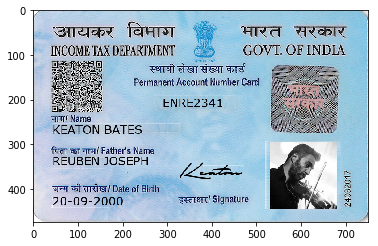

In [204]:
from skimage.io import imread
from skimage.filters import gaussian
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches
from skimage.color import label2rgb
from skimage.morphology import binary_dilation
#def find_stroke_width(img):

image = imread('resources/dummy_pans/pan_new/Keaton_Bates.jpg')
plt.imshow(image)
plt.show()

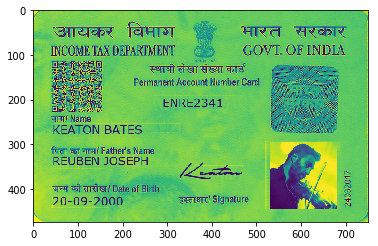

In [205]:
#step 1 : color to gray
from skimage import feature
from skimage.color import rgb2gray

image = rgb2gray(image)
plt.imshow(image)

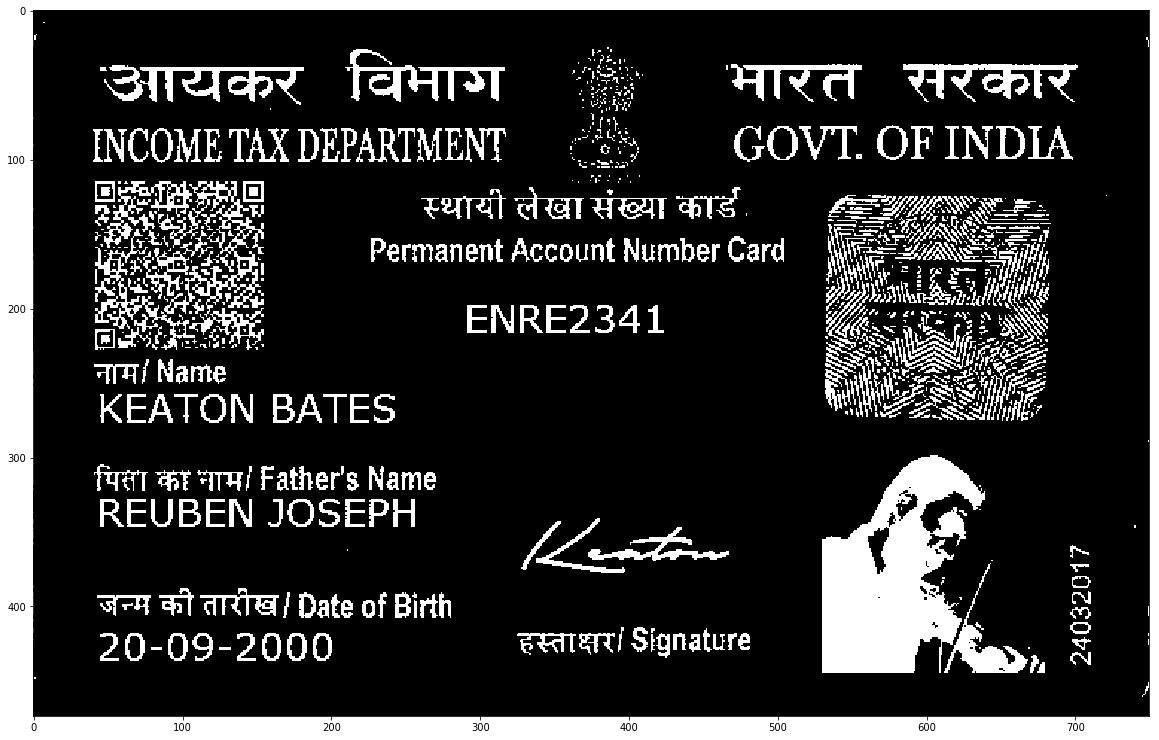

In [206]:
#step 2: binarize with otsu
from skimage.filters import threshold_otsu
import numpy as np

binary = np.ones(image.shape)
r,c = image.shape
divider = 2
for ri in range(divider):
    for ci in range(divider):
        region = image[int((ri/divider)*r):int((ri/divider+1/divider)*r), int((ci/divider)*c):int((ci/divider+1/divider)*c)]
        thresh = threshold_otsu(region)
        binary[int((ri/divider)*r):int((ri/divider+1/divider)*r), int((ci/divider)*c):int((ci/divider+1/divider)*c)] = region < thresh

plt.figure(figsize=(20,20))
plt.imshow(binary, cmap="gray")

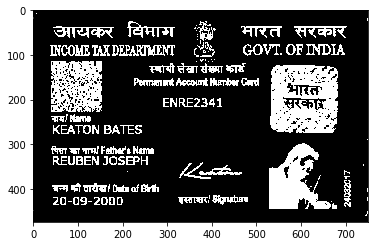

In [215]:
import math
from skimage.morphology import binary_dilation, binary_closing, square

# label image regions
label_image = label(binary)
al_areas = []
for region in regionprops(label_image):
    al_areas.append(region.area)

sqr = square(math.floor(math.sqrt(np.median(al_areas))))
bin_img = binary_closing(binary_dilation(binary, sqr), sqr)
plt.imshow(bin_img, cmap="gray")

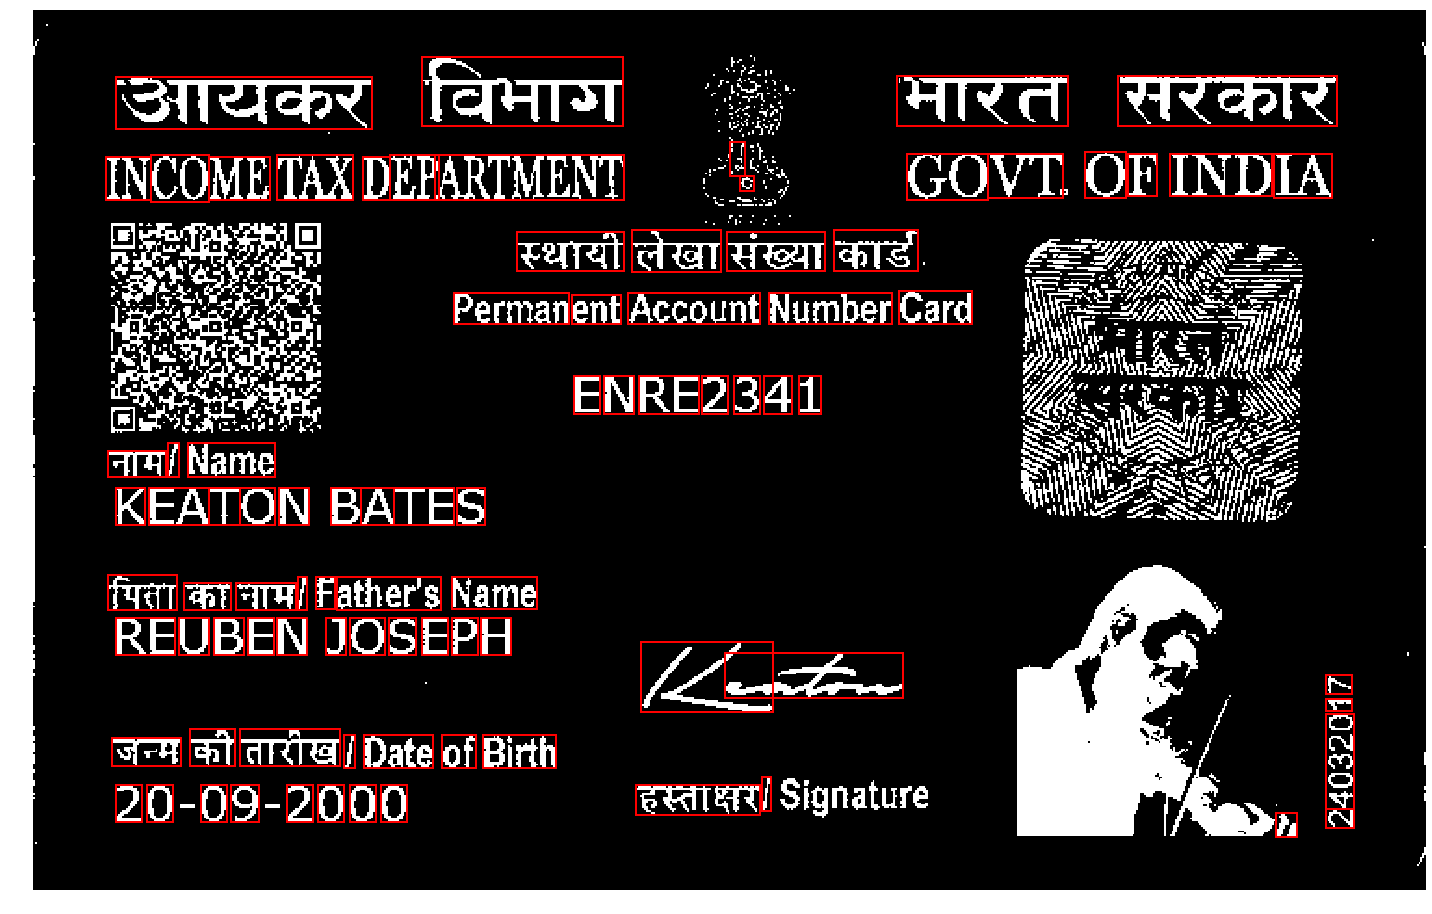

In [219]:
#### label_image = label(bin_img)
fig, ax = plt.subplots(figsize=(20, 20))

bin_img_area = bin_img.shape[0] * bin_img.shape[1]
label_image = label(bin_img)

def outside_vision_area(minr, minc, maxr, maxc, vision_region_minr, vision_region_minc, vision_region_maxr, vision_region_maxc):
    if minc < vision_region_minc and maxc < vision_region_minc:
        return True
    elif minr < vision_region_minr and maxr < vision_region_minr:
        return True
    elif minc > vision_region_maxc and maxc > vision_region_maxc:
        return True
    elif minr > vision_region_maxr and maxr > vision_region_maxr:
        return True
    return False 
    
ars = []
for region in regionprops(label_image):
    # take regions with large enough areas
    percentage_area = (region.area/bin_img_area)*100
    minr, minc, maxr, maxc = region.bbox
    r, c = binary.shape
    vision_region_minr = int(r*0.02)
    vision_region_minc = int(c*0.02)
    vision_region_maxr = r - vision_region_minr
    vision_region_maxc = c - vision_region_minc
    is_outside = outside_vision_area(minr, minc, maxr, maxc, vision_region_minr, vision_region_minc, vision_region_maxr, vision_region_maxc)
    if percentage_area > 0.01 and not is_outside:
        sub_img = binary[minr: maxr, minc: maxc]
        label_image, num = label(binary[minr: maxr, minc: maxc], return_num=True)
        if num < 10:
            h, w = sub_img.shape
            aratio = w/h
            
            ars.append(aratio)
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)

ax.imshow(binary, cmap="gray")
ax.set_axis_off()
plt.tight_layout()
plt.show()

1.0


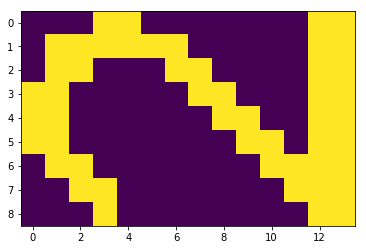

In [158]:
import math

def find_width_of_whites_pxls(array):
    swts = []
    count = 0
    for val in array:
        if val == 1:
            count+=1
        elif count > 0:
            swts.append(count)
            count = 0

    if count > 0:
        swts.append(count)
        
    return swts

def estimate_stroke_widths(img):
    r,c = img.shape
    swts = []
    # widths along the x axis
    for ri in range(r):
        swts = np.hstack((swts, find_width_of_whites_pxls(img[ri,:])))
        
    #widths along the y axis
    for ci in range(c):
        swts = np.hstack((swts, find_width_of_whites_pxls(img[:,ci])))

    median = np.median(swts)
    return median, swts

def get_stroke_width(img):
    angle_ranges = np.arange(30,50,1)
    stroke_width_cons = []
    for angle in angle_ranges:
        img_block = rotate(img, angle, resize=True)
        med, swts = estimate_stroke_widths(img_block)
        stroke_width_cons = np.hstack((stroke_width_cons, swts))

    return np.median(stroke_width_cons)
    
sub_img = binary[431:440, 697: 711]
# print(np.sum(sub_img, axis=1))
plt.imshow(sub_img)
print(get_stroke_width(sub_img))

In [140]:
angle_ranges = np.arange(10,40,1)
stroke_width_cons = []
for angle in angle_ranges:
    img_block = rotate(binary[26:62, 210:317], angle, resize=True)
    med, swts = estimate_stroke_widths(img_block)
    stroke_width_cons = np.hstack((stroke_width_cons, swts))
    
np.median(stroke_width_cons)

3.0